<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/Multiset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU


SuperEpoch 0: Epoch 0: Loss 0.5798794591871488
SuperEpoch 0: Epoch 10: Loss 0.5532488213219511
SuperEpoch 0: Epoch 20: Loss 0.5240819340217272
SuperEpoch 0: Epoch 30: Loss 0.4926275215259352
SuperEpoch 0: Epoch 40: Loss 0.4571293924255165
SuperEpoch 0: Epoch 50: Loss 0.4200715152276391
SuperEpoch 0: Epoch 60: Loss 0.38002872138136806
SuperEpoch 0: Epoch 70: Loss 0.3395122685590436
SuperEpoch 0: Epoch 80: Loss 0.29599251757663325
SuperEpoch 0: Epoch 90: Loss 0.25670586160495473
SuperEpoch 0: Epoch 100: Loss 0.21546448770491264
SuperEpoch 0: Epoch 110: Loss 0.17836799812636922
SuperEpoch 0: Epoch 120: Loss 0.14743041013661876
SuperEpoch 0: Epoch 130: Loss 0.11200851058396483
SuperEpoch 0: Epoch 140: Loss 0.08819107850084763
SuperEpoch 0: Epoch 150: Loss 0.07243656014453197
SuperEpoch 0: Epoch 160: Loss 0.05082354168205334
SuperEpoch 0: Epoch 170: Loss 0.03840465719806308
SuperEpoch 0: Epoch 180: Loss 0.02837320921364743
SuperEpoch 0: Epoch 190: Loss 0.02142978108163963
SuperEpoch 0: Epoc

SuperEpoch 1: Epoch 0: Loss 0.4070447372274718
SuperEpoch 1: Epoch 10: Loss 0.3310582489004719
SuperEpoch 1: Epoch 20: Loss 0.2431059919315091
SuperEpoch 1: Epoch 30: Loss 0.1788517651695444
SuperEpoch 1: Epoch 40: Loss 0.13365530645134568
SuperEpoch 1: Epoch 50: Loss 0.10243820325993862
SuperEpoch 1: Epoch 60: Loss 0.07904413583726884
SuperEpoch 1: Epoch 70: Loss 0.061845714734589094
SuperEpoch 1: Epoch 80: Loss 0.04921788366841988
SuperEpoch 1: Epoch 90: Loss 0.03875290826374858
SuperEpoch 1: Epoch 100: Loss 0.030788762855324957
SuperEpoch 1: Epoch 110: Loss 0.02508647935671198
SuperEpoch 1: Epoch 120: Loss 0.019849230375456276
SuperEpoch 1: Epoch 130: Loss 0.016405126634161216
SuperEpoch 1: Epoch 140: Loss 0.015067123407878089
SuperEpoch 1: Epoch 150: Loss 0.012875811249685832
SuperEpoch 1: Epoch 160: Loss 0.008203848794571856
SuperEpoch 1: Epoch 170: Loss 0.008576690737235729
SuperEpoch 1: Epoch 180: Loss 0.00520782578561205
SuperEpoch 1: Epoch 190: Loss 0.004985216508001388
SuperE

SuperEpoch 2: Epoch 0: Loss 0.40679100233419424
SuperEpoch 2: Epoch 10: Loss 0.3322480913807561
SuperEpoch 2: Epoch 20: Loss 0.24310452078001912
SuperEpoch 2: Epoch 30: Loss 0.17817297320397488
SuperEpoch 2: Epoch 40: Loss 0.13174244276373465
SuperEpoch 2: Epoch 50: Loss 0.09855629630163332
SuperEpoch 2: Epoch 60: Loss 0.07421153787291611
SuperEpoch 2: Epoch 70: Loss 0.056369264522132534
SuperEpoch 2: Epoch 80: Loss 0.04328967847232544
SuperEpoch 2: Epoch 90: Loss 0.03294455850076892
SuperEpoch 2: Epoch 100: Loss 0.026151289703216934
SuperEpoch 2: Epoch 110: Loss 0.019299239781437102
SuperEpoch 2: Epoch 120: Loss 0.01623066391439976
SuperEpoch 2: Epoch 130: Loss 0.01173147463011657
SuperEpoch 2: Epoch 140: Loss 0.010505135874547189
SuperEpoch 2: Epoch 150: Loss 0.00899312981897706
SuperEpoch 2: Epoch 160: Loss 0.007994354097972582
SuperEpoch 2: Epoch 170: Loss 0.007101508994498747
SuperEpoch 2: Epoch 180: Loss 0.004292759897059974
SuperEpoch 2: Epoch 190: Loss 0.006980931274899528
Supe

SuperEpoch 3: Epoch 0: Loss 0.40934945644407006
SuperEpoch 3: Epoch 10: Loss 0.33568474698519424
SuperEpoch 3: Epoch 20: Loss 0.24640029708574812
SuperEpoch 3: Epoch 30: Loss 0.18002229278152013
SuperEpoch 3: Epoch 40: Loss 0.13040193523659824
SuperEpoch 3: Epoch 50: Loss 0.09538465575292013
SuperEpoch 3: Epoch 60: Loss 0.07079349777863558
SuperEpoch 3: Epoch 70: Loss 0.052894071681707934
SuperEpoch 3: Epoch 80: Loss 0.03968702456442929
SuperEpoch 3: Epoch 90: Loss 0.030010150752369145
SuperEpoch 3: Epoch 100: Loss 0.023960862210120826
SuperEpoch 3: Epoch 110: Loss 0.017544789642745695
SuperEpoch 3: Epoch 120: Loss 0.013525407890621802
SuperEpoch 3: Epoch 130: Loss 0.0104824895611107
SuperEpoch 3: Epoch 140: Loss 0.008222295181719639
SuperEpoch 3: Epoch 150: Loss 0.006345378237301986
SuperEpoch 3: Epoch 160: Loss 0.005414404012474046
SuperEpoch 3: Epoch 170: Loss 0.004437218610912981
SuperEpoch 3: Epoch 180: Loss 0.003532330023337226
SuperEpoch 3: Epoch 190: Loss 0.005574723688525982
S

SuperEpoch 4: Epoch 0: Loss 0.4085140505101716
SuperEpoch 4: Epoch 10: Loss 0.33795785174481724
SuperEpoch 4: Epoch 20: Loss 0.250787567698059
SuperEpoch 4: Epoch 30: Loss 0.1843168423133549
SuperEpoch 4: Epoch 40: Loss 0.13257015723991444
SuperEpoch 4: Epoch 50: Loss 0.09799228846149793
SuperEpoch 4: Epoch 60: Loss 0.07188152964897976
SuperEpoch 4: Epoch 70: Loss 0.053460858815844045
SuperEpoch 4: Epoch 80: Loss 0.039978661216895424
SuperEpoch 4: Epoch 90: Loss 0.03137794794832557
SuperEpoch 4: Epoch 100: Loss 0.022653192769867634
SuperEpoch 4: Epoch 110: Loss 0.01775063225800083
SuperEpoch 4: Epoch 120: Loss 0.013234380391227166
SuperEpoch 4: Epoch 130: Loss 0.010212756664499662
SuperEpoch 4: Epoch 140: Loss 0.012292984916782195
SuperEpoch 4: Epoch 150: Loss 0.0069158228699445715
SuperEpoch 4: Epoch 160: Loss 0.005304184898074165
SuperEpoch 4: Epoch 170: Loss 0.00558245212318626
SuperEpoch 4: Epoch 180: Loss 0.009976957653107984
SuperEpoch 4: Epoch 190: Loss 0.0033844997165213614
Sup

SuperEpoch 5: Epoch 0: Loss 0.410207529108556
SuperEpoch 5: Epoch 10: Loss 0.3394475453745304
SuperEpoch 5: Epoch 20: Loss 0.25461638741070153
SuperEpoch 5: Epoch 30: Loss 0.1893051678751738
SuperEpoch 5: Epoch 40: Loss 0.1367531702102836
SuperEpoch 5: Epoch 50: Loss 0.09934238671115272
SuperEpoch 5: Epoch 60: Loss 0.07351954752764102
SuperEpoch 5: Epoch 70: Loss 0.05434182671520349
SuperEpoch 5: Epoch 80: Loss 0.04040009906962394
SuperEpoch 5: Epoch 90: Loss 0.032734422973943744
SuperEpoch 5: Epoch 100: Loss 0.02313176856729574
SuperEpoch 5: Epoch 110: Loss 0.018785947268670253
SuperEpoch 5: Epoch 120: Loss 0.014151233271669339
SuperEpoch 5: Epoch 130: Loss 0.011340696870427516
SuperEpoch 5: Epoch 140: Loss 0.008691215571064297
SuperEpoch 5: Epoch 150: Loss 0.007040322538711649
SuperEpoch 5: Epoch 160: Loss 0.005581068919235325
SuperEpoch 5: Epoch 170: Loss 0.00462971178814513
SuperEpoch 5: Epoch 180: Loss 0.00370957416368608
SuperEpoch 5: Epoch 190: Loss 0.009675285650209343
SuperEpo

SuperEpoch 6: Epoch 0: Loss 0.4097341474749087
SuperEpoch 6: Epoch 10: Loss 0.341603808112143
SuperEpoch 6: Epoch 20: Loss 0.2607864998852708
SuperEpoch 6: Epoch 30: Loss 0.19433599918113667
SuperEpoch 6: Epoch 40: Loss 0.14529792456379956
SuperEpoch 6: Epoch 50: Loss 0.1068403257465718
SuperEpoch 6: Epoch 60: Loss 0.07894999814342805
SuperEpoch 6: Epoch 70: Loss 0.05905708235147833
SuperEpoch 6: Epoch 80: Loss 0.04381366316351601
SuperEpoch 6: Epoch 90: Loss 0.033027653341144374
SuperEpoch 6: Epoch 100: Loss 0.029826556417272183
SuperEpoch 6: Epoch 110: Loss 0.01938155225124797
SuperEpoch 6: Epoch 120: Loss 0.014550667109145437
SuperEpoch 6: Epoch 130: Loss 0.01206900310051303
SuperEpoch 6: Epoch 140: Loss 0.008736777982703187
SuperEpoch 6: Epoch 150: Loss 0.007092331989430012
SuperEpoch 6: Epoch 160: Loss 0.0056126346195185545
SuperEpoch 6: Epoch 170: Loss 0.00624844130025215
SuperEpoch 6: Epoch 180: Loss 0.004385464877703437
SuperEpoch 6: Epoch 190: Loss 0.003111900330555614
SuperEp

SuperEpoch 7: Epoch 0: Loss 0.41053450380898987
SuperEpoch 7: Epoch 10: Loss 0.3457155909427919
SuperEpoch 7: Epoch 20: Loss 0.26769089103843047
SuperEpoch 7: Epoch 30: Loss 0.2041631143690106
SuperEpoch 7: Epoch 40: Loss 0.15063367520279267
SuperEpoch 7: Epoch 50: Loss 0.11305045076415654
SuperEpoch 7: Epoch 60: Loss 0.08423503145998648
SuperEpoch 7: Epoch 70: Loss 0.06301067752875288
SuperEpoch 7: Epoch 80: Loss 0.04693818104856979
SuperEpoch 7: Epoch 90: Loss 0.03536618520694848
SuperEpoch 7: Epoch 100: Loss 0.02704492491888713
SuperEpoch 7: Epoch 110: Loss 0.020103708594994947
SuperEpoch 7: Epoch 120: Loss 0.016104605753630014
SuperEpoch 7: Epoch 130: Loss 0.015012784410273133
SuperEpoch 7: Epoch 140: Loss 0.013770613536203886
SuperEpoch 7: Epoch 150: Loss 0.009098758885791527
SuperEpoch 7: Epoch 160: Loss 0.007294864089188065
SuperEpoch 7: Epoch 170: Loss 0.005613209599628096
SuperEpoch 7: Epoch 180: Loss 0.020327995058473717
SuperEpoch 7: Epoch 190: Loss 0.007663042767650373
Supe

SuperEpoch 8: Epoch 0: Loss 0.40627161329564865
SuperEpoch 8: Epoch 10: Loss 0.3451836049913718
SuperEpoch 8: Epoch 20: Loss 0.2715839001320489
SuperEpoch 8: Epoch 30: Loss 0.2108748400437089
SuperEpoch 8: Epoch 40: Loss 0.16039991120519687
SuperEpoch 8: Epoch 50: Loss 0.1186011471855649
SuperEpoch 8: Epoch 60: Loss 0.08963374776974826
SuperEpoch 8: Epoch 70: Loss 0.06824165728339317
SuperEpoch 8: Epoch 80: Loss 0.05196286400547385
SuperEpoch 8: Epoch 90: Loss 0.0400671315693698
SuperEpoch 8: Epoch 100: Loss 0.02947698449722289
SuperEpoch 8: Epoch 110: Loss 0.02330125865357191
SuperEpoch 8: Epoch 120: Loss 0.017273905306252675
SuperEpoch 8: Epoch 130: Loss 0.013282763241589097
SuperEpoch 8: Epoch 140: Loss 0.010626647155712446
SuperEpoch 8: Epoch 150: Loss 0.015542063096419983
SuperEpoch 8: Epoch 160: Loss 0.006428892269967502
SuperEpoch 8: Epoch 170: Loss 0.005230550331315241
SuperEpoch 8: Epoch 180: Loss 0.006189179328817681
SuperEpoch 8: Epoch 190: Loss 0.004003975631120925
SuperEpo

SuperEpoch 9: Epoch 0: Loss 0.40600409178050817
SuperEpoch 9: Epoch 10: Loss 0.34620798319272217
SuperEpoch 9: Epoch 20: Loss 0.2766416486439964
SuperEpoch 9: Epoch 30: Loss 0.21832611707188404
SuperEpoch 9: Epoch 40: Loss 0.16625312676815562
SuperEpoch 9: Epoch 50: Loss 0.12461389024455383
SuperEpoch 9: Epoch 60: Loss 0.09531517458528899
SuperEpoch 9: Epoch 70: Loss 0.07138823388387572
SuperEpoch 9: Epoch 80: Loss 0.054375677625420886
SuperEpoch 9: Epoch 90: Loss 0.042270094773713934
SuperEpoch 9: Epoch 100: Loss 0.03192474165345728
SuperEpoch 9: Epoch 110: Loss 0.02347451603119855
SuperEpoch 9: Epoch 120: Loss 0.01880847546044459
SuperEpoch 9: Epoch 130: Loss 0.014413594753038744
SuperEpoch 9: Epoch 140: Loss 0.020921745034426575
SuperEpoch 9: Epoch 150: Loss 0.00838159010440975
SuperEpoch 9: Epoch 160: Loss 0.0131946524062172
SuperEpoch 9: Epoch 170: Loss 0.0060475551511112524
SuperEpoch 9: Epoch 180: Loss 0.004524723874913966
SuperEpoch 9: Epoch 190: Loss 0.0053698724922394735
Supe

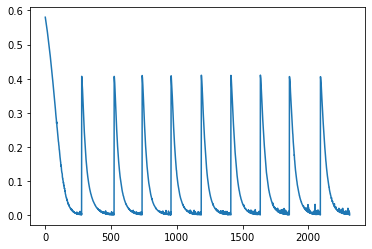

In [3]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import regenerate_PWMatrix
from scipy.stats import wasserstein_distance as WD

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        typed_trimmed_specs.append(specs[i])

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                ar[i][j] = r
                ar[j][i] = 1-r

    return ar

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_net(model, train_size, super_train_size):
    loss_values = []
    for super_epoch in range(super_train_size):
      full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
      train_y = get_LT(full_m.to_numpy())
      
      pbar2=tqdm(range(train_size))
      pbar2.set_description(f'Training Neural Net: SuperEpoch {super_epoch}')
      for epoch in pbar2:

          npcm = np.zeros(len(trimmed_specs))
          size = rd.randint(25, 235)
          subset = rd.sample(trimmed_specs, size)
          subset_lam = (full_m.loc[subset, subset]).to_numpy()
          cm = predict_community_fullnp(subset_lam, subset, verb=False)

          for i in range(len(cm)):
              npcm[trimmed_specs.index(subset[i])] = cm[i]

          
          optimizer.zero_grad()

          x, y = npcm, train_y

          input = torch.from_numpy(x).float().to(device)
          true_y = torch.FloatTensor(y).to(device)
          output = model(input).to(device)
          loss = criterion(output, true_y).to(device)
          s = sqrt(loss.item()/(231*461))
          if (epoch % 10)==0:
            print(f'SuperEpoch {super_epoch}: Epoch {epoch}: Loss {s}')
          loss_values.append(s)
          loss.backward()
          optimizer.step()
          if s<=0.002:
            break

    return loss_values

if __name__=='__main__':
    super_train_size, train_size, test_size, param, = 10, 3000, 25, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)

    lv = train_net(net, train_size=train_size, super_train_size=super_train_size)

    torch.save(net.state_dict(), path)
    plt.plot(lv)
    plt.savefig('Loss')
    plt.show()